In [406]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from tqdm.auto import trange

In [407]:
# Configuration parameters
scale = 1
params = {
    # domain parameters
    'domain_size': 5.0 * scale, # size of the domain
    'grid_points': 128,


    # Physics parameters
    'omega': 20.0 / scale,
    'source_position': (-0.5 * scale, -1.5 * scale),

    # Dielectric parameters
    'has_dielectric': False,
    'dielectric_center': (1.0 * scale, 1.5 * scale),
    'dielectric_radius': 0.3 * scale,
    'dielectric_eps': 2.0,

    # Network parameters
    'hidden_features': 256,
    'hidden_layers': 3,
    'omega_0': 30,

    # Training parameters,
    'num_epochs': 600,
    'learning_rate': 2e-5,
    'batch_size': 512,
    'print_every': 50,

    # Scheduler parameters
    'use_scheduler': True,
    'scheduler_patience': 100,
    'scheduler_factor': 0.5,
    'scheduler_min_lr': 1e-9,
}

In [408]:
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, omega_0, is_first=False):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.linear = nn.Linear(in_features, out_features)
        # Initialize weights according to SIREN paper
        with torch.no_grad():
            if is_first:
                self.linear.weight.uniform_(-1. / in_features, 1. / in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / in_features) / omega_0, np.sqrt(6 / in_features) / omega_0)

    def forward(self, x):
        return torch.sin(self.omega_0 * self.linear(x))

class SIREN(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, omega_0):
        super().__init__()
        self.net = []
        # First layer
        self.net.append(SineLayer(in_features, hidden_features, omega_0, is_first=True))
        # Hidden layers
        for _ in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, omega_0, is_first=False))
        # Output layer
        final_layer = nn.Linear(hidden_features, out_features)
        with torch.no_grad():
            final_layer.weight.uniform_(-np.sqrt(6 / hidden_features) / omega_0, np.sqrt(6 / hidden_features) / omega_0)
        self.net.append(final_layer)
        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        return self.net(x)

In [409]:
class HelmholtzSolver:
    def __init__(self, param):
        # Extract parameters with defaults
        self.domain_size = param['domain_size']
        self.grid_points = param['grid_points']
        self.omega = param['omega']
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # print(f"device: {self.device}")
        # Initialize SIREN model
        self.model = SIREN(
            in_features=2,
            hidden_features=param['hidden_features'],
            hidden_layers=param['hidden_layers'],
            out_features=2,
            omega_0=param['omega_0'],
        ).to(self.device)

        # Source parameters
        self.source_position = param['source_position']

        # Dielectric parameters
        self.has_dielectric = param['has_dielectric']
        dielectric_center = param['dielectric_center']
        self.dielectric_center = torch.tensor(dielectric_center, device=self.device)
        self.dielectric_radius = param['dielectric_radius']
        self.dielectric_eps = param['dielectric_eps']

        # Setup optiizer
        self.learning_rate = param['learning_rate']
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # Setup scheduler
        self.use_scheduler = param['use_scheduler']
        if self.use_scheduler:
            self.scheduler = lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                mode='min',
                factor=param['scheduler_factor'],
                patience=param['scheduler_patience'],
                min_lr=param['scheduler_min_lr']
            )

        self.batch_size = param['batch_size']
        self.print_every = param['print_every']

        self.create_grid()

    def create_grid(self):
        x = np.linspace(-self.domain_size / 2, self.domain_size / 2, self.grid_points)
        y = np.linspace(-self.domain_size / 2, self.domain_size / 2, self.grid_points)
        self.xx, self.yy = np.meshgrid(x, y)

        # Create a grid of points
        x_flat = self.xx.flatten()
        y_flat = self.yy.flatten()
        self.grid_points_flat = torch.tensor(np.stack([x_flat, y_flat], axis=1), dtype=torch.float32, device=self.device)

    def add_dielectric_circle(self, center, radius, eps):
        self.has_dielectric = True
        self.dielectric_center = torch.tensor(center, device=self.device)
        self.dielectric_radius = radius
        self.dielectric_eps = eps

    def get_permittivity(self, x):
        eps = torch.ones(x.shape[0], 1, device=self.device)

        if self.has_dielectric:
            dist = torch.sqrt(torch.sum((x - self.dielectric_center)**2, dim=1, keepdim=True))
            eps = torch.where(dist < self.dielectric_radius, self.dielectric_eps * torch.ones_like(eps), eps)

        return eps

    def get_source(self, x):
        batch_size = x.shape[0]

        jz_real = torch.zeros(batch_size, 1, device=self.device)
        jz_imag = torch.zeros(batch_size, 1, device=self.device)

        source_pos_tensor = torch.tensor(self.source_position, dtype=torch.float32, device=self.device)
        dist = torch.sum((x - source_pos_tensor)**2, dim=1)
        closest_idx = torch.argmin(dist)

        jz_real[closest_idx] = 1.

        return torch.hstack((jz_real, jz_imag))

    def compute_laplacian(self, x):
        x.requires_grad_(True)

        y_pred = self.model(x)

        y_real, y_imag = y_pred[:, 0:1], y_pred[:, 1:2]

        grad_outputs = torch.ones_like(y_real)
        grad_y_real = torch.autograd.grad(
            outputs = y_real,
            inputs = x,
            grad_outputs = grad_outputs,
            create_graph=True
        )[0]

        # Compute second derivatives for real part
        laplacian_real = 0
        for i in range(x.shape[1]):
            grad2_y_real = torch.autograd.grad(
                outputs = grad_y_real[:, i:i+1],
                inputs = x,
                grad_outputs = torch.ones_like(grad_y_real[:, i:i+1]),
                create_graph=True
            )[0][:, i:i+1]
            laplacian_real = laplacian_real + grad2_y_real

        grad_outputs = torch.ones_like(y_imag)
        grad_y_imag = torch.autograd.grad(
            outputs = y_imag,
            inputs = x,
            grad_outputs = grad_outputs,
            create_graph=True
        )[0]

        # Compute second derivatives for imag part
        laplacian_imag = 0
        for i in range(x.shape[1]):
            grad2_y_imag = torch.autograd.grad(
                outputs = grad_y_imag[:, i:i+1],
                inputs = x,
                grad_outputs = torch.ones_like(grad_y_imag[:, i:i+1]),
                create_graph=True
            )[0][:, i:i+1]
            laplacian_imag = laplacian_imag + grad2_y_imag

        return torch.hstack((laplacian_real, laplacian_imag))

    def helmholtz_residual(self, x):
        y_pred = self.model(x)
        y_real, y_imag = y_pred[:, 0:1], y_pred[:, 1:2]

        laplacian = self.compute_laplacian(x)

        laplacian_real, laplacian_imag = laplacian[:, 0:1], laplacian[:, 1:2]

        eps = self.get_permittivity(x)

        jz = self.get_source(x)

        jz_real, jz_imag = jz[:, 0:1], jz[:, 1:2]

        residual_real = -laplacian_real - eps * self.omega ** 2 * y_real + self.omega * jz_imag
        residual_imag = -laplacian_imag - eps * self.omega ** 2 * y_imag - self.omega * jz_real

        return torch.cat([residual_real, residual_imag], dim=1)


    def square_bc_loss(self, x):
        boundary_width = 0.1 * self.domain_size / 2

        dist_from_left = torch.abs(x[:, 0:1] + self.domain_size / 2)
        dist_from_right = torch.abs(x[:, 0:1] - self.domain_size / 2)
        dist_from_bottom = torch.abs(x[:, 1:2] + self.domain_size / 2)
        dist_from_top = torch.abs(x[:, 1:2] - self.domain_size / 2)

        left_mask = (dist_from_left < boundary_width).float()
        right_mask = (dist_from_right < boundary_width).float()
        bottom_mask = (dist_from_bottom < boundary_width).float()
        top_mask = (dist_from_top < boundary_width).float()

        y_pred = self.model(x)
        y_real, y_imag = y_pred[:, 0:1], y_pred[:, 1:2]

        x.requires_grad_(True)

        grad_y_real = torch.autograd.grad(
            outputs = y_real,
            inputs = x,
            grad_outputs = torch.ones_like(y_real),
            create_graph=True
        )[0]

        grad_y_imag = torch.autograd.grad(
            outputs = y_imag,
            inputs = x,
            grad_outputs = torch.ones_like(y_imag),
            create_graph=True
        )[0]

        # normal = [-1, 0]
        normal_x = -left_mask
        normal_y = torch.zeros_like(left_mask)
        normal = torch.cat([normal_x, normal_y], dim=1)

        dn_y_real_left = torch.sum(grad_y_real * normal, dim=1, keepdim=True)
        dn_y_imag_left = torch.sum(grad_y_imag * normal, dim=1, keepdim=True)

        # Sommerfeld condition: dn/dn + ik * u = 0
        bc_loss_left = left_mask * ((dn_y_real_left + self.omega * y_imag) ** 2
                                    + (dn_y_imag_left - self.omega * y_real) ** 2)

        # normal = [1, 0]
        normal_x = right_mask
        normal_y = torch.zeros_like(right_mask)
        normal = torch.cat([normal_x, normal_y], dim=1)

        dn_y_real_right = torch.sum(grad_y_real * normal, dim=1, keepdim=True)
        dn_y_imag_right = torch.sum(grad_y_imag * normal, dim=1, keepdim=True)


        bc_loss_right = right_mask * ((dn_y_real_right + self.omega * y_imag) ** 2
                                    + (dn_y_imag_right - self.omega * y_real) ** 2)

        # normal = [0, -1]
        normal_x = torch.zeros_like(bottom_mask)
        normal_y = -bottom_mask
        normal = torch.cat([normal_x, normal_y], dim=1)

        dn_y_real_bottom = torch.sum(grad_y_real * normal, dim=1, keepdim=True)
        dn_y_imag_bottom = torch.sum(grad_y_imag * normal, dim=1, keepdim=True)

        bc_loss_bottom = bottom_mask * ((dn_y_real_bottom + self.omega * y_imag) ** 2
                                    + (dn_y_imag_bottom - self.omega * y_real) ** 2)

        # normal = [0, 1]
        normal_x = torch.zeros_like(top_mask)
        normal_y = top_mask
        normal = torch.cat([normal_x, normal_y], dim=1)

        dn_y_real_top = torch.sum(grad_y_real * normal, dim=1, keepdim=True)
        dn_y_imag_top = torch.sum(grad_y_imag * normal, dim=1, keepdim=True)

        bc_loss_top = top_mask * ((dn_y_real_top + self.omega * y_imag) ** 2
                                    + (dn_y_imag_top - self.omega * y_real) ** 2)

        bc_loss = bc_loss_left + bc_loss_right + bc_loss_bottom + bc_loss_top

        return bc_loss.mean()

    def train(self, num_epochs, print_every):
        losses = []
        physical_losses = []
        bc_losses = []
        lr_history = []
        x_train = self.grid_points_flat

        batch_size = min(self.batch_size, x_train.shape[0])
        num_batches = (x_train.shape[0] + batch_size - 1) // batch_size
        for epoch in trange(num_epochs, desc = "Training PINN"):
            epoch_loss = 0
            epoch_physical_loss = 0
            epoch_bc_loss = 0

            indices = torch.randperm(x_train.shape[0], device=self.device)
            x_shuffled = x_train[indices]

            for batch in range(num_batches):
                self.optimizer.zero_grad()

                start_index = batch * batch_size
                end_index = min((batch + 1) * batch_size, x_train.shape[0])
                x_batch = x_shuffled[start_index:end_index]

                residuals = self.helmholtz_residual(x_batch)
                physics_loss = torch.mean(residuals ** 2)

                bc_loss = self.square_bc_loss(x_batch)

                loss = physics_loss + bc_loss

                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item() * (end_index - start_index)
                epoch_physical_loss += physics_loss.item() * (end_index - start_index)
                epoch_bc_loss += bc_loss.item() * (end_index - start_index)

            epoch_loss /=  x_train.shape[0]
            epoch_physical_loss /=  x_train.shape[0]
            epoch_bc_loss /=  x_train.shape[0]

            if self.use_scheduler:
                self.scheduler.step(epoch_loss)

            current_lr = self.optimizer.param_groups[0]['lr']
            lr_history.append(current_lr)

            losses.append(epoch_loss)
            physical_losses.append(epoch_physical_loss)
            bc_losses.append(epoch_bc_loss)

            if (epoch + 1) % print_every == 0:
                print(f"Epoch {epoch + 1} Loss: {epoch_loss}, physic loss: {epoch_physical_loss}, bc loss: {epoch_bc_loss}")
                if epoch > 0 and lr_history[-1] != lr_history[-2]:
                    print(f"Learning rate: {current_lr}")

        self.losses = losses
        self.physical_losses = physical_losses
        self.bc_losses = bc_losses
        self.lr_history = lr_history

        return losses

    def plot_losses(self):
        fig, ax1 = plt.subplots(figsize=(10, 6))

        epochs = np.arange(1, len(self.losses) + 1)
        ax1.plot(epochs, self.losses, label="Total Loss", color="tab:blue", lw=2)
        ax1.plot(epochs, self.physical_losses, label="Physics Loss", color="tab:orange", lw=1.5)
        ax1.plot(epochs, self.bc_losses, label="Boundary Loss", color="tab:green", lw=1.5)

        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.set_title("Loss Curves")
        ax1.set_yscale('log')
        ax1.grid(True)
        ax1.legend()

        if self.use_scheduler:
            ax2 = ax1.twinx()
            ax2.plot(epochs, self.lr_history, label="Learning Rate", color="tab:red", linestyle="--")
            ax2.set_ylabel("Learning Rate", color="tab:red")
            ax2.tick_params(axis='y', labelcolor="tab:red")

        plt.tight_layout()
        plt.show()

    def predict(self):
        self.model.eval()
        with torch.no_grad():
            input_grid = self.grid_points_flat
            output = self.model(input_grid)

            real = output[:, 0].reshape(self.grid_points, self.grid_points).cpu().numpy()
            imag = output[:, 1].reshape(self.grid_points, self.grid_points).cpu().numpy()
            magnitude = np.sqrt(real**2 + imag**2)

            self.pred_real = real
            self.pred_imag = imag
            self.pred_magnitude = magnitude

    def visualize(self):
        if not hasattr(self, 'pred_real') or not hasattr(self, 'pred_imag'):
            print("Please run predict() before visualize().")
            return

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        extent = [-self.domain_size / 2, self.domain_size / 2, -self.domain_size / 2, self.domain_size / 2]

        # Imaginary part of E_z
        im1 = axes[0].imshow(self.pred_imag, extent=extent, cmap='RdBu', origin='lower')
        axes[0].set_title('Imag(E_z)')
        plt.colorbar(im1, ax=axes[0])

        # Magnitude
        im2 = axes[1].imshow(self.pred_magnitude, extent=extent, cmap='viridis', origin='lower')
        axes[1].set_title('|E_z|')
        plt.colorbar(im2, ax=axes[1])

        # Add dielectric circle (if present)
        if self.has_dielectric:
            for ax in axes:
                dielectric_circle = Circle(
                    self.dielectric_center.cpu().numpy(),
                    self.dielectric_radius,
                    fill=False,
                    color='black',
                    linewidth=1.5
                )
                ax.add_patch(dielectric_circle)

        # Add source point
        # source_pos = self.source_position
        # for ax in axes:
        #     ax.plot(source_pos[0], source_pos[1], marker='o', markersize=6, color='white', label='Source')
        #     ax.set_xlabel('x')
        #     ax.set_ylabel('y')

        plt.tight_layout()
        plt.show()




In [410]:
solver = HelmholtzSolver(params)
if params['has_dielectric']:
    solver.add_dielectric_circle(
        center=params['dielectric_center'],
        radius=params['dielectric_radius'],
        eps=params['dielectric_eps'],
    )
solver.train(num_epochs=params['num_epochs'], print_every=params['print_every'])


Training PINN:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 50 Loss: 0.3892216319218278, physic loss: 0.3882009219378233, bc loss: 0.0010207108462054748
Epoch 100 Loss: 0.32501489762216806, physic loss: 0.32439993042498827, bc loss: 0.000614966999819444
Epoch 150 Loss: 0.2666897331364453, physic loss: 0.2662564101628959, bc loss: 0.00043332295535947196
Epoch 200 Loss: 0.31150479544885457, physic loss: 0.31113454699516296, bc loss: 0.00037025061647000257
Epoch 250 Loss: 0.31629527173936367, physic loss: 0.3159917814191431, bc loss: 0.0003034893852600362
Epoch 300 Loss: 0.3096809131093323, physic loss: 0.3094229931011796, bc loss: 0.00025791871439651004
Epoch 350 Loss: 0.23521357926074415, physic loss: 0.23504818859510124, bc loss: 0.00016539268040105526
Epoch 400 Loss: 0.2102717710658908, physic loss: 0.21015332569368184, bc loss: 0.00011844458481391484
Epoch 450 Loss: 0.22890558559447527, physic loss: 0.22882858337834477, bc loss: 7.70017358036057e-05
Epoch 500 Loss: 0.21959256194531918, physic loss: 0.21952976076863706, bc loss: 6.279978

[72.6684137582779,
 20.60573375225067,
 9.905491888523102,
 6.1118505746126175,
 4.192173682153225,
 3.1427912041544914,
 2.4373917877674103,
 1.9800626523792744,
 1.6139652915298939,
 1.338597409427166,
 1.1756673529744148,
 1.004873365163803,
 0.9160012640058994,
 0.8533985447138548,
 0.8579532466828823,
 0.714916056022048,
 0.6513284128159285,
 0.6720207994803786,
 0.6041127825155854,
 0.5745835183188319,
 0.5921310828998685,
 0.4956426937133074,
 0.49067459255456924,
 0.4738167058676481,
 0.47281941026449203,
 0.441764528863132,
 0.4417363479733467,
 0.4151036059483886,
 0.4441271647810936,
 0.46863996842876077,
 0.4718383732251823,
 0.4811243023723364,
 0.4136563912034035,
 0.39681875240057707,
 0.5249176579527557,
 0.44159945100545883,
 0.4148002960719168,
 0.346620608586818,
 0.41389050148427486,
 0.3742146221920848,
 0.4513463252224028,
 0.4745763470418751,
 0.40720412228256464,
 0.38958079810254276,
 0.4570276979357004,
 0.35840812139213085,
 0.3766989912837744,
 0.42639358527

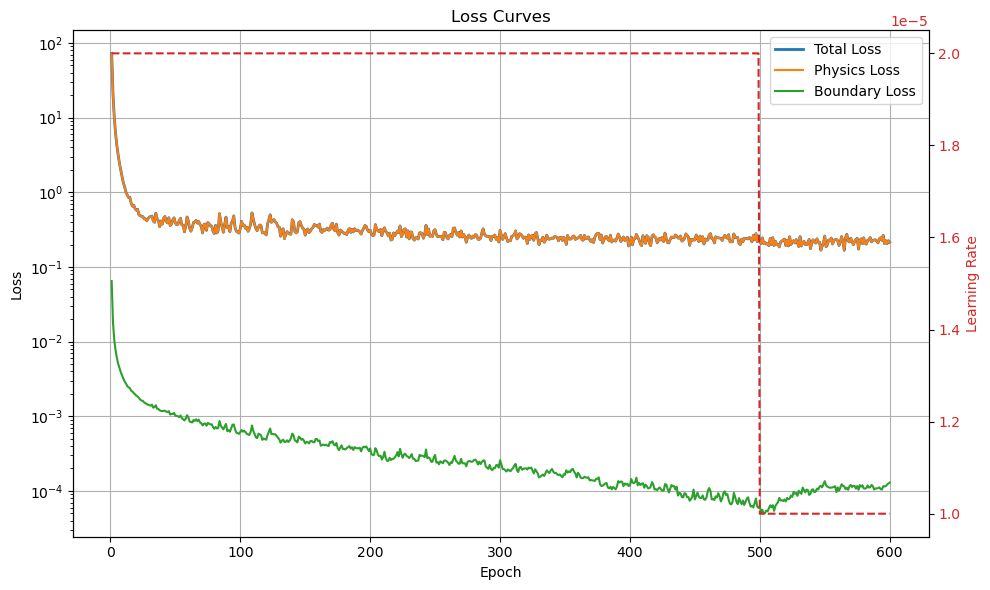

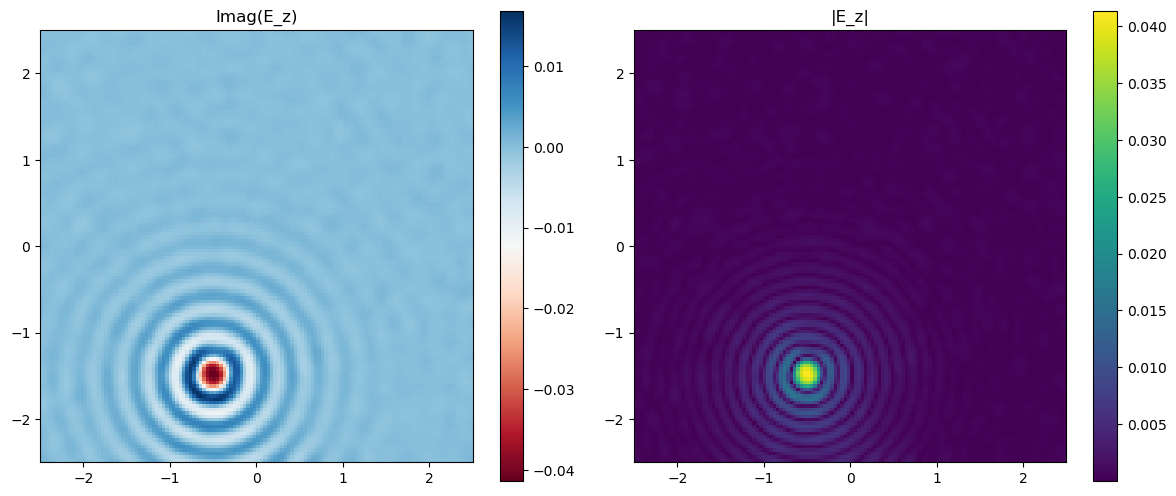

In [411]:

solver.plot_losses()
solver.predict()
solver.visualize()

In [412]:
solver2 = HelmholtzSolver(params)

solver2.add_dielectric_circle(
    center=params['dielectric_center'],
    radius=params['dielectric_radius'],
    eps=params['dielectric_eps'],
)
solver2.train(num_epochs=params['num_epochs'], print_every=params['print_every'])


Training PINN:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 50 Loss: 0.3528450089506805, physic loss: 0.35060602030716836, bc loss: 0.0022389886471501086
Epoch 100 Loss: 0.35544069949537516, physic loss: 0.35420959582552314, bc loss: 0.001231106656632619
Epoch 150 Loss: 0.29183099465444684, physic loss: 0.2910265033133328, bc loss: 0.0008044902679102961
Epoch 200 Loss: 0.2088636764092371, physic loss: 0.2083849882474169, bc loss: 0.0004786892450283631
Epoch 250 Loss: 0.26116656488738954, physic loss: 0.26058825361542404, bc loss: 0.0005783106444141595
Epoch 300 Loss: 0.24346322484780103, physic loss: 0.2429381248075515, bc loss: 0.0005251024276731187
Epoch 350 Loss: 0.26373402238823473, physic loss: 0.26328313746489584, bc loss: 0.0004508850906859152
Epoch 400 Loss: 0.19119138945825398, physic loss: 0.190750191337429, bc loss: 0.00044119826725363964
Epoch 450 Loss: 0.2254062972497195, physic loss: 0.22494502598419785, bc loss: 0.0004612693510352983
Epoch 500 Loss: 0.23577023448888212, physic loss: 0.23532503785099834, bc loss: 0.000445196

[255.88023018836975,
 52.504955410957336,
 28.29414564371109,
 17.85288992524147,
 12.287436455488205,
 9.036425322294235,
 6.95541088283062,
 5.4531877636909485,
 4.421713225543499,
 3.6695977598428726,
 3.090474046766758,
 2.673952415585518,
 2.286860380321741,
 1.9953449182212353,
 1.7931127697229385,
 1.574382834136486,
 1.48771196231246,
 1.2816326022148132,
 1.2052710987627506,
 1.0968222711235285,
 1.0054486747831106,
 0.9018707349896431,
 0.8560461662709713,
 0.820615803822875,
 0.783428780734539,
 0.686273081228137,
 0.6747785322368145,
 0.6341016702353954,
 0.6266144290566444,
 0.6332964841276407,
 0.5709762759506702,
 0.502660958096385,
 0.5242739580571651,
 0.4809381924569607,
 0.4881016882136464,
 0.45882023591548204,
 0.45972136966884136,
 0.4495356781408191,
 0.42888857144862413,
 0.41810833429917693,
 0.3889744412153959,
 0.3914952608756721,
 0.3889522426761687,
 0.3764764443039894,
 0.3862592573277652,
 0.37689818860962987,
 0.3500661929138005,
 0.3465863741002977,
 0.

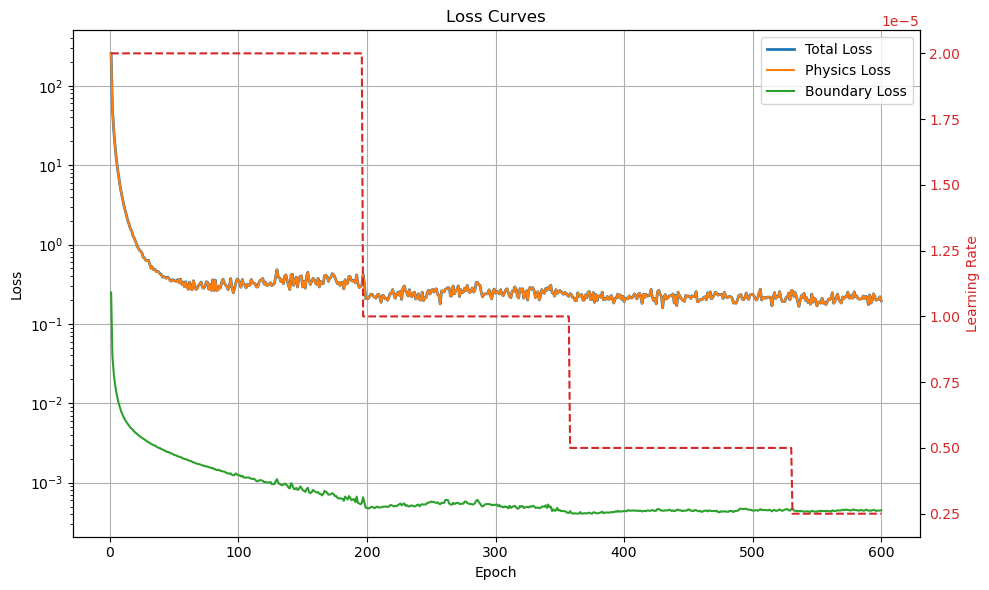

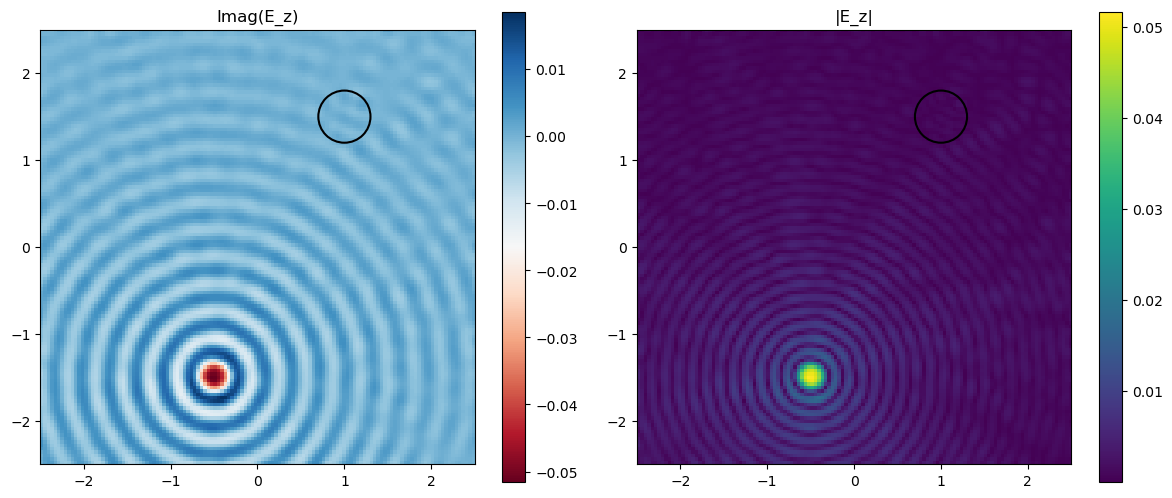

In [413]:

solver2.plot_losses()
solver2.predict()
solver2.visualize()

Training PINN:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 50 Loss: 0.2833281368948519, physic loss: 0.28144987812265754, bc loss: 0.0018782593906507827
Epoch 100 Loss: 0.37479332042858005, physic loss: 0.37371169636026025, bc loss: 0.0010816207523021149
Epoch 150 Loss: 0.34594720927998424, physic loss: 0.3452525995671749, bc loss: 0.0006946083285583882
Epoch 200 Loss: 0.2431248907232657, physic loss: 0.24267103953752667, bc loss: 0.0004538502298601088
Epoch 250 Loss: 0.26412186538800597, physic loss: 0.2636481879744679, bc loss: 0.00047367643855977803
Epoch 300 Loss: 0.2501925954129547, physic loss: 0.24976583966054022, bc loss: 0.0004267544391041156
Epoch 350 Loss: 0.24828069563955069, physic loss: 0.24791231169365346, bc loss: 0.0003683832956085098
Epoch 400 Loss: 0.18660736177116632, physic loss: 0.1862573444377631, bc loss: 0.0003500168031678186
Epoch 450 Loss: 0.23849176801741123, physic loss: 0.2381801016163081, bc loss: 0.0003116639391009812
Epoch 500 Loss: 0.2128111874917522, physic loss: 0.21249586041085422, bc loss: 0.00031532

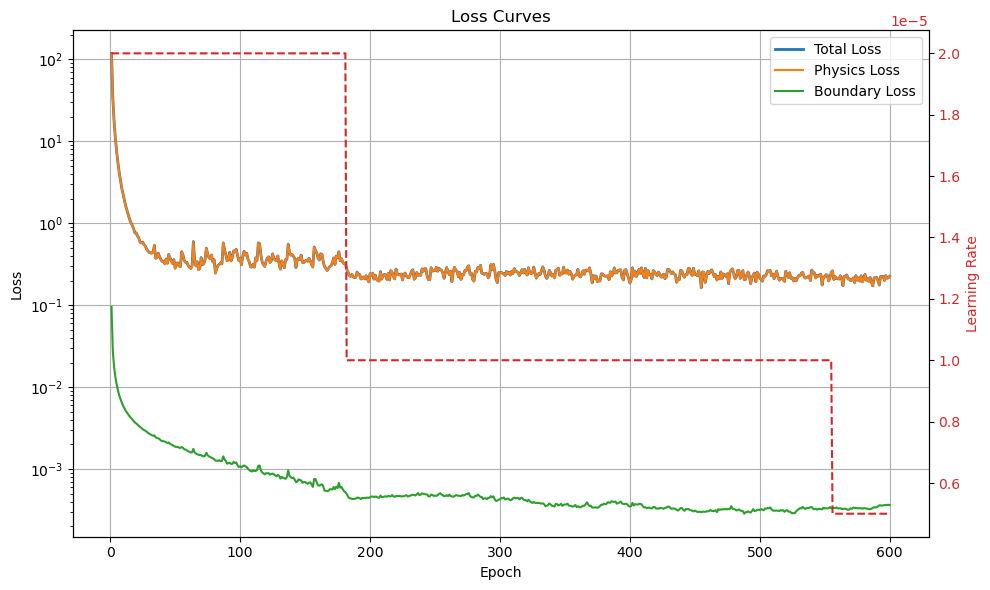

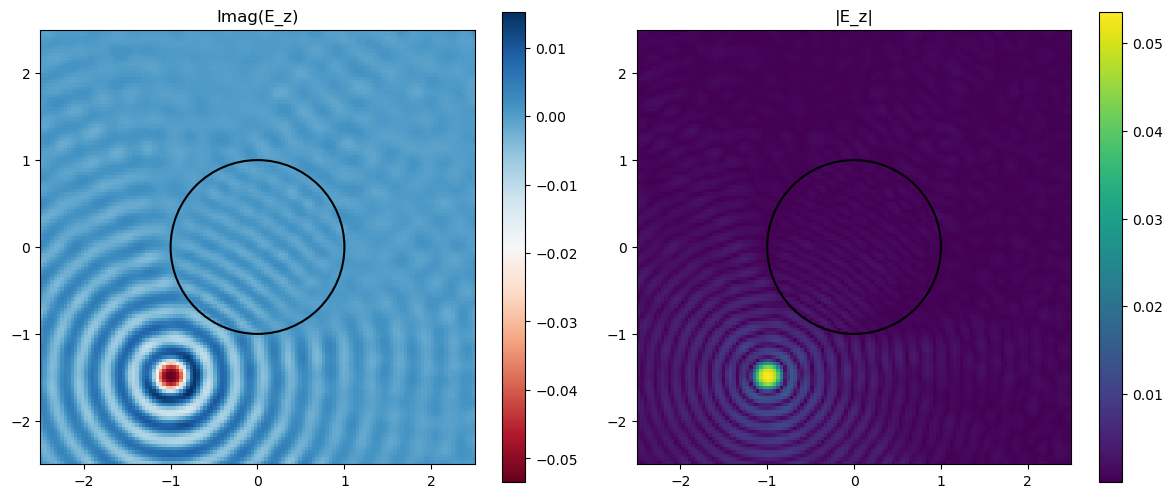

In [417]:
params3 = {
    # domain parameters
    'domain_size': 5.0 * scale,  # size of the domain
    'grid_points': 128,

    # Physics parameters
    'omega': 20.0 / scale,
    'source_position': (-1.0 * scale, -1.5 * scale),

    # Dielectric parameters
    'has_dielectric': True,
    'dielectric_center': (0.0 * scale, 0.0 * scale),
    'dielectric_radius': 1.0 * scale,
    'dielectric_eps': 2.0,

    # Network parameters
    'hidden_features': 256,
    'hidden_layers': 3,
    'omega_0': 30,

    # Training parameters,
    'num_epochs': 600,
    'learning_rate': 2e-5,
    'batch_size': 512,
    'print_every': 50,

    # Scheduler parameters
    'use_scheduler': True,
    'scheduler_patience': 100,
    'scheduler_factor': 0.5,
    'scheduler_min_lr': 1e-9,
}
solver3 = HelmholtzSolver(params3)
if params3['has_dielectric']:
    solver3.add_dielectric_circle(
        center=params3['dielectric_center'],
        radius=params3['dielectric_radius'],
        eps=params3['dielectric_eps'],
    )
solver3.train(num_epochs=params3['num_epochs'], print_every=params3['print_every'])


solver3.plot_losses()
solver3.predict()
solver3.visualize()

In [415]:
params4 = {
    # domain parameters
    'domain_size': 5.0 * scale,  # size of the domain
    'grid_points': 128,

    # Physics parameters
    'omega': 20.0 / scale,
    'source_position': (-1.0 * scale, -0.5 * scale),

    # Dielectric parameters
    'has_dielectric': True,
    'dielectric_center': (.5 * scale, 1.0 * scale),
    'dielectric_radius': 0.5 * scale,
    'dielectric_eps': 2.0,
    'dielectric_center2': (1.0 * scale, -1.0 * scale),
    'dielectric_radius2': 0.3 * scale,
    'dielectric_eps2': 2.0,

    # Network parameters
    'hidden_features': 256,
    'hidden_layers': 3,
    'omega_0': 30,

    # Training parameters,
    'num_epochs': 600,
    'learning_rate': 2e-5,
    'batch_size': 512,
    'print_every': 50,

    # Scheduler parameters
    'use_scheduler': True,
    'scheduler_patience': 100,
    'scheduler_factor': 0.5,
    'scheduler_min_lr': 1e-9,
}
solver4 = HelmholtzSolver(params2)
if params4['has_dielectric']:
    solver4.add_dielectric_circle(
        center=params2['dielectric_center'],
        radius=params2['dielectric_radius'],
        eps=params2['dielectric_eps'],
    )

if params4['has_dielectric']:
    solver4.add_dielectric_circle(
        center=params4['dielectric_center'],
        radius=params4['dielectric_radius'],
        eps=params4['dielectric_eps'],
    )
    solver4.add_dielectric_circle(
        center=params4['dielectric_center2'],
        radius=params4['dielectric_radius2'],
        eps=params4['dielectric_eps2'],
    )

solver4.train(num_epochs=params4['num_epochs'], print_every=params4['print_every'])



Training PINN:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 50 Loss: 0.36474756384268403, physic loss: 0.3636675390880555, bc loss: 0.0010800248019222636
Epoch 100 Loss: 0.41623717173933983, physic loss: 0.41559448884800076, bc loss: 0.0006426820573324221
Epoch 150 Loss: 0.30238515534438193, physic loss: 0.30209383158944547, bc loss: 0.0002913249259108852
Epoch 200 Loss: 0.2906151581555605, physic loss: 0.29040550091303885, bc loss: 0.0002096578687087458
Epoch 250 Loss: 0.2904295986518264, physic loss: 0.290262833237648, bc loss: 0.0001667642673055525
Epoch 300 Loss: 0.27918273117393255, physic loss: 0.27905110036954284, bc loss: 0.00013163048083697504
Epoch 350 Loss: 0.3112328352872282, physic loss: 0.31112103327177465, bc loss: 0.00011180102319485741
Epoch 400 Loss: 0.23495565506163985, physic loss: 0.2348969152662903, bc loss: 5.87391789395042e-05
Epoch 450 Loss: 0.26397061557509005, physic loss: 0.26392615772783756, bc loss: 4.44584188699082e-05
Epoch 500 Loss: 0.2187676428584382, physic loss: 0.21874788170680404, bc loss: 1.976055744

[81.1992039680481,
 23.169882655143738,
 11.205182760953903,
 6.972437098622322,
 4.852958232164383,
 3.6744342893362045,
 2.728726513683796,
 2.2095335721969604,
 1.809459000825882,
 1.5302723422646523,
 1.3372954167425632,
 1.1676942724734545,
 1.0497149806469679,
 0.9599575959146023,
 0.8258994687348604,
 0.7117949537932873,
 0.7403858229517937,
 0.6619362281635404,
 0.6351119028404355,
 0.6137482197955251,
 0.6110104452818632,
 0.5325759099796414,
 0.5244752699509263,
 0.4908909760415554,
 0.49428670201450586,
 0.46174479462206364,
 0.5581442788243294,
 0.4302535937167704,
 0.5062642218545079,
 0.43024515034630895,
 0.45419924100860953,
 0.3932072501629591,
 0.43453215062618256,
 0.4182301415130496,
 0.35655407747253776,
 0.34102713875472546,
 0.326387673150748,
 0.4043101938441396,
 0.4331534458324313,
 0.3886698600836098,
 0.3252472097519785,
 0.44860124308615923,
 0.40787652740255,
 0.36593076027929783,
 0.459693412296474,
 0.3886653119698167,
 0.3705678260885179,
 0.41772399097

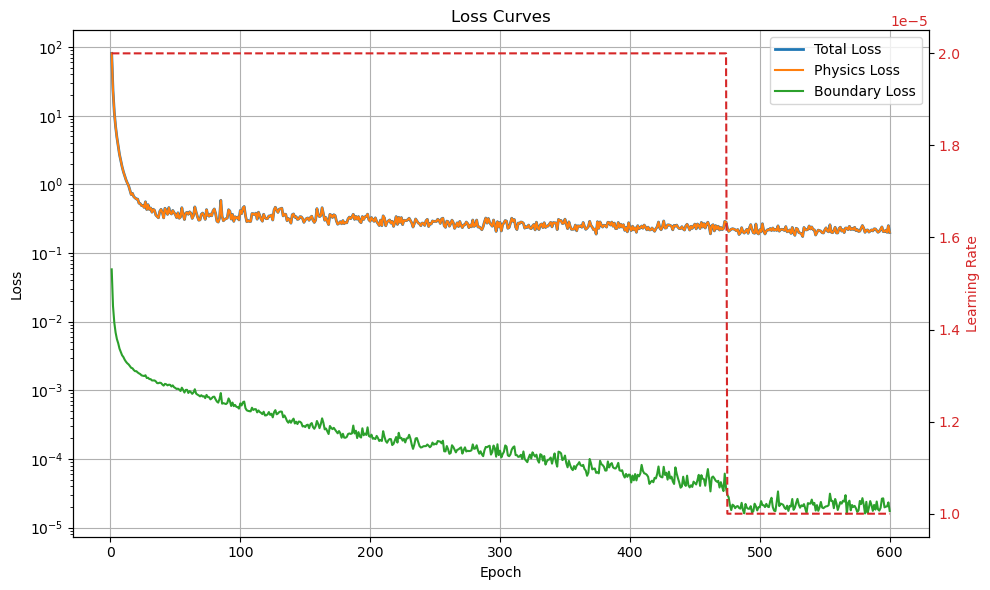

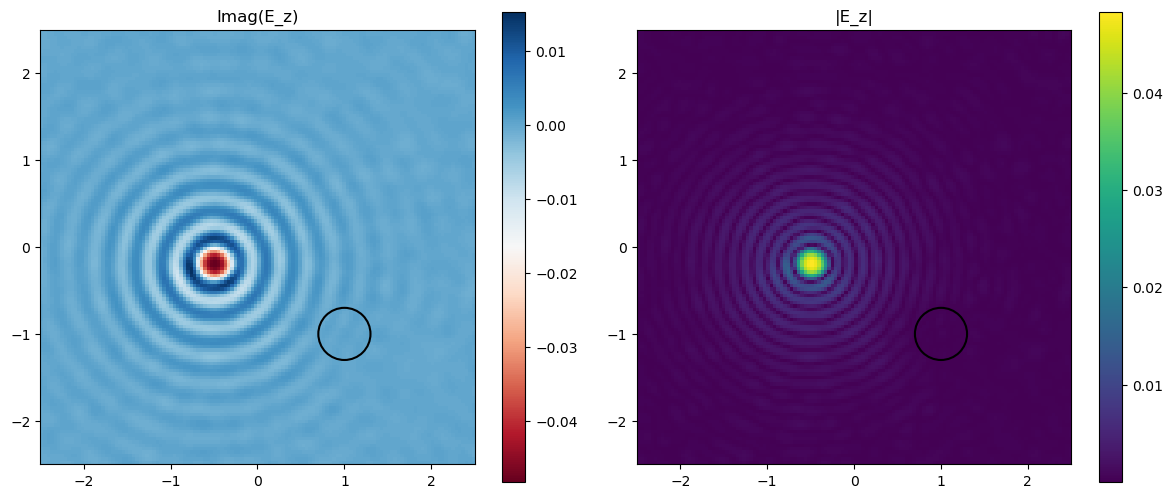

In [416]:
solver4.plot_losses()
solver4.predict()
solver4.visualize()